<a href="https://colab.research.google.com/github/umaimayasir789/Elevvo-ML-Task-2/blob/main/Movie_recommendation_system_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 1. Upload the zip file
from google.colab import files
uploaded = files.upload()   # select dataset.zip (MovieLens 100k)

# 2. Extract the zip file
import zipfile
import os

with zipfile.ZipFile("dataset.zip", "r") as zip_ref:
    zip_ref.extractall("/content/")

# 3. Check folder contents
print(os.listdir("/content/ml-100k"))

# 4. Load ratings and movies
import pandas as pd

ratings = pd.read_csv("/content/ml-100k/u.data", sep="\t",
                      names=["user_id","movie_id","rating","timestamp"])

movies = pd.read_csv("/content/ml-100k/u.item", sep="|", encoding="latin-1", header=None,
                     names=["movie_id","title","release_date","video_release_date","IMDb_URL",
                            "unknown","Action","Adventure","Animation","Children","Comedy",
                            "Crime","Documentary","Drama","Fantasy","Film-Noir","Horror",
                            "Musical","Mystery","Romance","Sci-Fi","Thriller","War","Western"])

print(ratings.head())
print(movies.head())


Saving dataset.zip to dataset (2).zip
['u.data', 'u4.test', 'ub.test', 'ub.base', 'ua.base', 'u1.base', 'u.item', 'u1.test', 'u2.test', 'u4.base', 'u5.test', 'allbut.pl', 'mku.sh', 'u.info', 'ua.test', 'u3.test', 'u3.base', 'u.genre', 'u.occupation', 'u5.base', 'u.user', 'README', 'u2.base']
   user_id  movie_id  rating  timestamp
0      196       242       3  881250949
1      186       302       3  891717742
2       22       377       1  878887116
3      244        51       2  880606923
4      166       346       1  886397596
   movie_id              title release_date  video_release_date  \
0         1   Toy Story (1995)  01-Jan-1995                 NaN   
1         2   GoldenEye (1995)  01-Jan-1995                 NaN   
2         3  Four Rooms (1995)  01-Jan-1995                 NaN   
3         4  Get Shorty (1995)  01-Jan-1995                 NaN   
4         5     Copycat (1995)  01-Jan-1995                 NaN   

                                            IMDb_URL  unknown  A

In [ ]:
# 5. Merge ratings with movies on movie_id
data = pd.merge(ratings, movies[["movie_id", "title"]], on="movie_id")
print(data.head())

# 6. Create a user-item matrix (users as rows, movies as columns)
user_item_matrix = data.pivot_table(index="user_id", columns="title", values="rating")
print(user_item_matrix.head())

# 7. Fill missing values with 0 (unrated movies)
user_item_matrix = user_item_matrix.fillna(0)

# 8. Compute user similarity using cosine similarity
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

user_similarity = cosine_similarity(user_item_matrix)
user_similarity_df = pd.DataFrame(user_similarity,
                                  index=user_item_matrix.index,
                                  columns=user_item_matrix.index)

print("User similarity matrix shape:", user_similarity_df.shape)

# 9. Function to recommend movies for a given user
def recommend_movies(user_id, num_recommendations=5):
    # Find similar users
    similar_users = user_similarity_df[user_id].sort_values(ascending=False).index[1:]

    # Movies already watched by this user
    user_movies = set(data[data.user_id == user_id]["title"])

    recommendations = {}
    for sim_user in similar_users:
        sim_user_movies = data[data.user_id == sim_user][["title","rating"]]
        for _, row in sim_user_movies.iterrows():
            if row["title"] not in user_movies:  # unseen movies
                recommendations[row["title"]] = recommendations.get(row["title"], 0) + row["rating"]
        if len(recommendations) >= num_recommendations * 2:  # stop early
            break

    sorted_recs = sorted(recommendations.items(), key=lambda x: x[1], reverse=True)
    return [title for title, score in sorted_recs[:num_recommendations]]

# 10. Example: Recommend 5 movies for user 1
print("Recommendations for User 1:")
print(recommend_movies(1, 5))


   user_id  movie_id  rating  timestamp                       title
0      196       242       3  881250949                Kolya (1996)
1      186       302       3  891717742    L.A. Confidential (1997)
2       22       377       1  878887116         Heavyweights (1994)
3      244        51       2  880606923  Legends of the Fall (1994)
4      166       346       1  886397596         Jackie Brown (1997)
title    'Til There Was You (1997)  1-900 (1994)  101 Dalmatians (1996)  \
user_id                                                                   
1                              NaN           NaN                    2.0   
2                              NaN           NaN                    NaN   
3                              NaN           NaN                    NaN   
4                              NaN           NaN                    NaN   
5                              NaN           NaN                    2.0   

title    12 Angry Men (1957)  187 (1997)  2 Days in the Valley (19

In [ ]:
# 11. Compute item similarity using cosine similarity
item_similarity = cosine_similarity(user_item_matrix.T)
item_similarity_df = pd.DataFrame(item_similarity,
                                  index=user_item_matrix.columns,
                                  columns=user_item_matrix.columns)

# 12. Function to recommend similar movies (Item-based)
def recommend_movies_item_based(movie_name, num_recommendations=5):
    similar_movies = item_similarity_df[movie_name].sort_values(ascending=False).index[1:num_recommendations+1]
    return list(similar_movies)

# 13. Example: Recommend similar movies to "Star Wars (1977)"
print("Item-based Recommendations for 'Star Wars (1977)':")
print(recommend_movies_item_based("Star Wars (1977)", 5))


Item-based Recommendations for 'Star Wars (1977)':
['Return of the Jedi (1983)', 'Raiders of the Lost Ark (1981)', 'Empire Strikes Back, The (1980)', 'Toy Story (1995)', 'Godfather, The (1972)']


In [ ]:
from sklearn.decomposition import TruncatedSVD

# 14. Apply SVD for dimensionality reduction
svd = TruncatedSVD(n_components=20, random_state=42)
latent_matrix = svd.fit_transform(user_item_matrix)
latent_movie_matrix = svd.components_

# 15. Predict ratings by reconstructing the matrix
predicted_ratings = np.dot(latent_matrix, latent_movie_matrix)

# 16. Function for SVD-based recommendations
def recommend_movies_svd(user_id, num_recommendations=5):
    user_row = user_id - 1  # adjust index (user_id starts at 1)
    scores = predicted_ratings[user_row]
    seen_movies = set(data[data.user_id == user_id]["title"])

    movie_scores = list(zip(user_item_matrix.columns, scores))
    movie_scores = sorted(movie_scores, key=lambda x: x[1], reverse=True)

    recommendations = [title for title, score in movie_scores if title not in seen_movies]
    return recommendations[:num_recommendations]

# 17. Example: Recommend 5 movies for user 1 using SVD
print("SVD Recommendations for User 1:")
print(recommend_movies_svd(1, 5))


SVD Recommendations for User 1:
['Trainspotting (1996)', 'Sense and Sensibility (1995)', 'Close Shave, A (1995)', 'E.T. the Extra-Terrestrial (1982)', 'Heathers (1989)']


In [ ]:
# 18. Precision@K Evaluation
def precision_at_k(user_id, k=5, method="user"):
    if method == "user":
        recs = recommend_movies(user_id, k)
    elif method == "item":
        user_movies = set(data[data.user_id == user_id]["title"])
        first_movie = list(user_movies)[0]
        recs = recommend_movies_item_based(first_movie, k)
    else:  # SVD
        recs = recommend_movies_svd(user_id, k)

    actual = set(data[data.user_id == user_id]["title"])
    hits = len(set(recs) & actual)
    return hits / k

# 19. Example: Precision@5 for User 1
print("Precision@5 (User-based):", precision_at_k(1, 5, method="user"))
print("Precision@5 (Item-based):", precision_at_k(1, 5, method="item"))
print("Precision@5 (SVD):", precision_at_k(1, 5, method="svd"))


Precision@5 (User-based): 0.0
Precision@5 (Item-based): 0.8
Precision@5 (SVD): 0.0


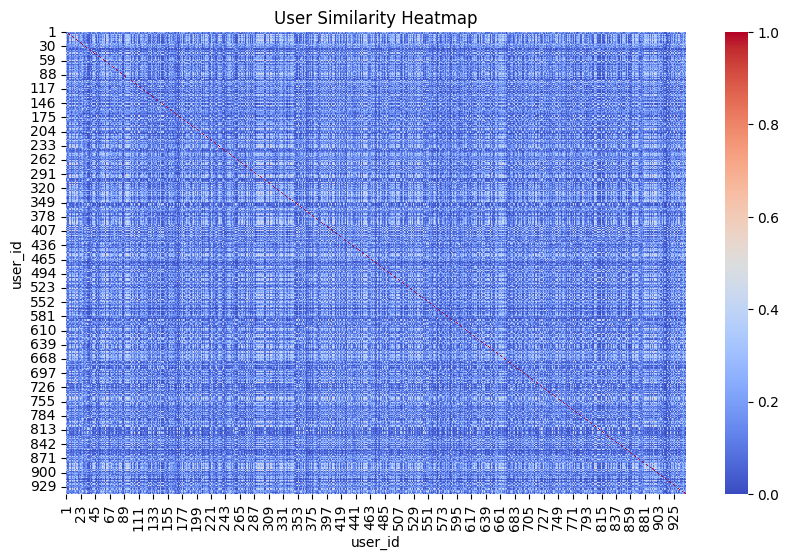

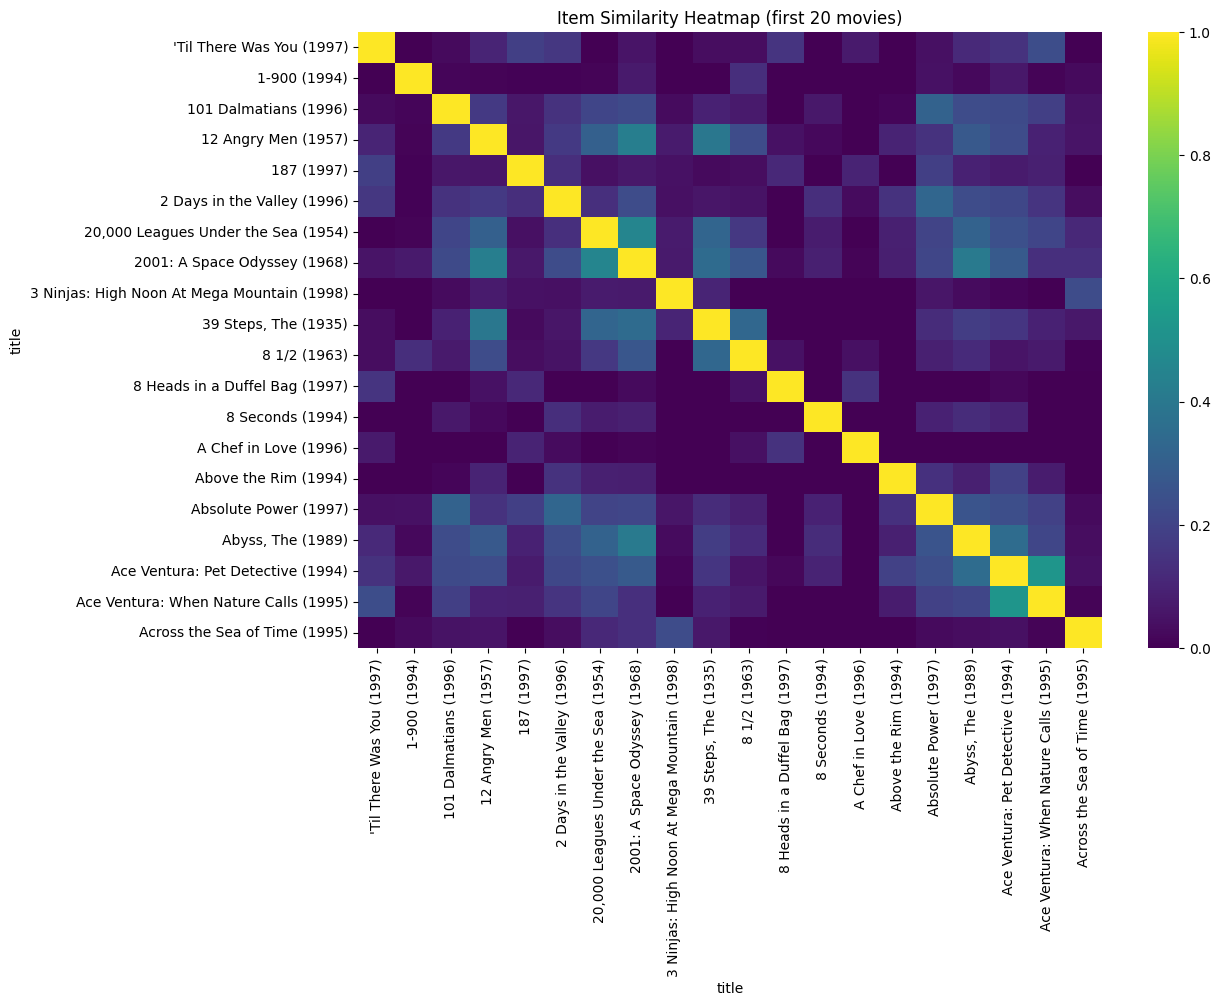

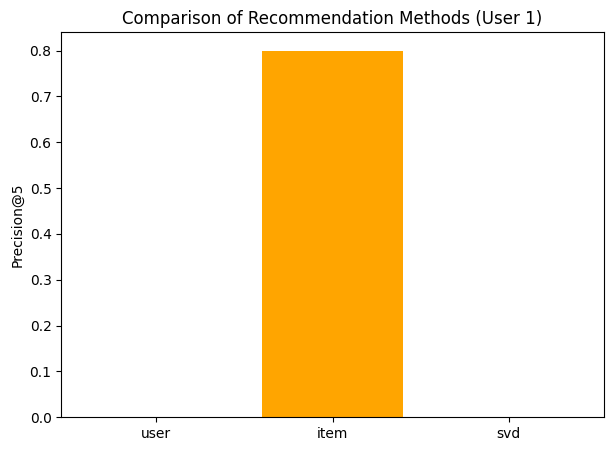

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 20. Heatmap of User Similarity
plt.figure(figsize=(10,6))
sns.heatmap(user_similarity_df, cmap="coolwarm")
plt.title("User Similarity Heatmap")
plt.show()

# 21. Heatmap of Item Similarity (subset for readability)
subset_movies = user_item_matrix.columns[:20]  # first 20 movies
plt.figure(figsize=(12,8))
sns.heatmap(item_similarity_df.loc[subset_movies, subset_movies], cmap="viridis")
plt.title("Item Similarity Heatmap (first 20 movies)")
plt.show()

# 22. Compare Precision@K Across Methods
methods = ["user", "item", "svd"]
scores = [precision_at_k(1, 5, method=m) for m in methods]

plt.figure(figsize=(7,5))
plt.bar(methods, scores, color=["skyblue","orange","green"])
plt.ylabel("Precision@5")
plt.title("Comparison of Recommendation Methods (User 1)")
plt.show()
